Uncomment the following lines if running on Google Colaboratory. This will install versions of PyTorch and CuPy that work with our package, and then download the package files from the GitHub repo.

Restart the runtime when prompted to in the output of the cell.

In [ ]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cupy-cuda110
# !git clone https://github.com/BouazzaSE/NeuralXVA
# !mv NeuralXVA/* ./
# !rm -R NeuralXVA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from simulation.diffusion_engine import DiffusionEngine
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = '100'

In [2]:
np.random.seed(0)

## Simulation parameters

* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in the article);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in the article);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of the article:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

In [3]:
num_coarse_steps = 100
dT = 0.1
num_fine_per_coarse = 25
dt = 0.004
num_paths = 2**15
num_inner_paths = 1024
num_defs_per_path = 256
num_rates = 10
num_spreads = 9
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.4, 0.03, num_rates)
rates_params['b'] = np.random.normal(0.03, 0.001, num_rates)
rates_params['sigma'] = np.abs(np.random.normal(0.0025, 0.00025, num_rates))
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.25, 0.025, num_rates-1))
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameters
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.5, 0.03, num_spreads)
spreads_params['b'] = np.random.normal(0.01, 0.001, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.0075, 0.00075, num_spreads))
initial_values[2*num_rates-1:] = 0.01

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0
vanilla_specs = np.empty(num_vanillas,
                         dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])

num_irs = 500
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 0.2  # Reset frequency
irs_specs['notional'] = 10000. * \
    ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5)))
     * np.random.choice(range(1, 11), num_irs))  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs))  # Swap rate, not needed, swaps are priced at par anyway
irs_specs['num_resets'] = np.random.randint(6, 51, num_irs, np.int32)  # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates-1, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs,
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

Next, we select the GPU. Should be `cuda:0` if there is only one GPU available. This is where both the simulation and the training/inference are going to be performed.

In [4]:
device = torch.device('cuda:0')

We then instantiate the diffusion engine:

In [5]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device.index)

Successfully compiled all kernels.


The shared memory on the GPU is used as a buffer where batches of the product specifications (which are the same for all threads) are stored (we could have put them in the constant memory but the latter is almost fully occupied by the simulation parameters). The `50` in the first and second arguments indicate that we want a size of `50` for those batches when pricing respectively the interest rate swaps and the vanilla options.

We launch a first set of simulations:

In [6]:
diffusion_engine.generate_batch(fused=True)

cuda_diffuse_and_price elapsed time: 838.346 ms


Once the simulations are done, we get:
* paths of the diffusion risk factors in `diffusion_engine.X`;
* paths of a numerical integral of the domestic short rate in `diffusion_engine.dom_rate_integral`;
* paths of the default indicators (as packed bits) in `diffusion_engine.def_indicators`;
* paths of the mark-to-market for each counterparty in `diffusion_engine.mtm_by_cpty`.

`diffusion_engine.X[t, i, j]` will then correspond to the value at the time-step `t` of the `i`-th diffusion risk factor on the `j`-th Monte Carlo realization of the diffusion simulation.

`diffusion_engine.mtm_by_cpty[t, i, j]` will correspond to the mark-to-market at the time-step `t` of the `i`-th counterparty on the `j`-th Monte Carlo realization of the diffusion simulation.

Also, since default indicators are stored as packed bits in 8-bit integers, `(diffusion_engine.def_indicators[t, i//8, j, k] & (1<<(i%8))) != 0` will yield the default indicator at the time-step `t` of the `i`-th counterparty on the `j`-th realization of the default indicator given the path of diffusion risk factors on the `k`-th realization of the diffusion simulation.

## MtM profiles

Given the previous hints, we can for example plot MtM profiles for each counterparty:

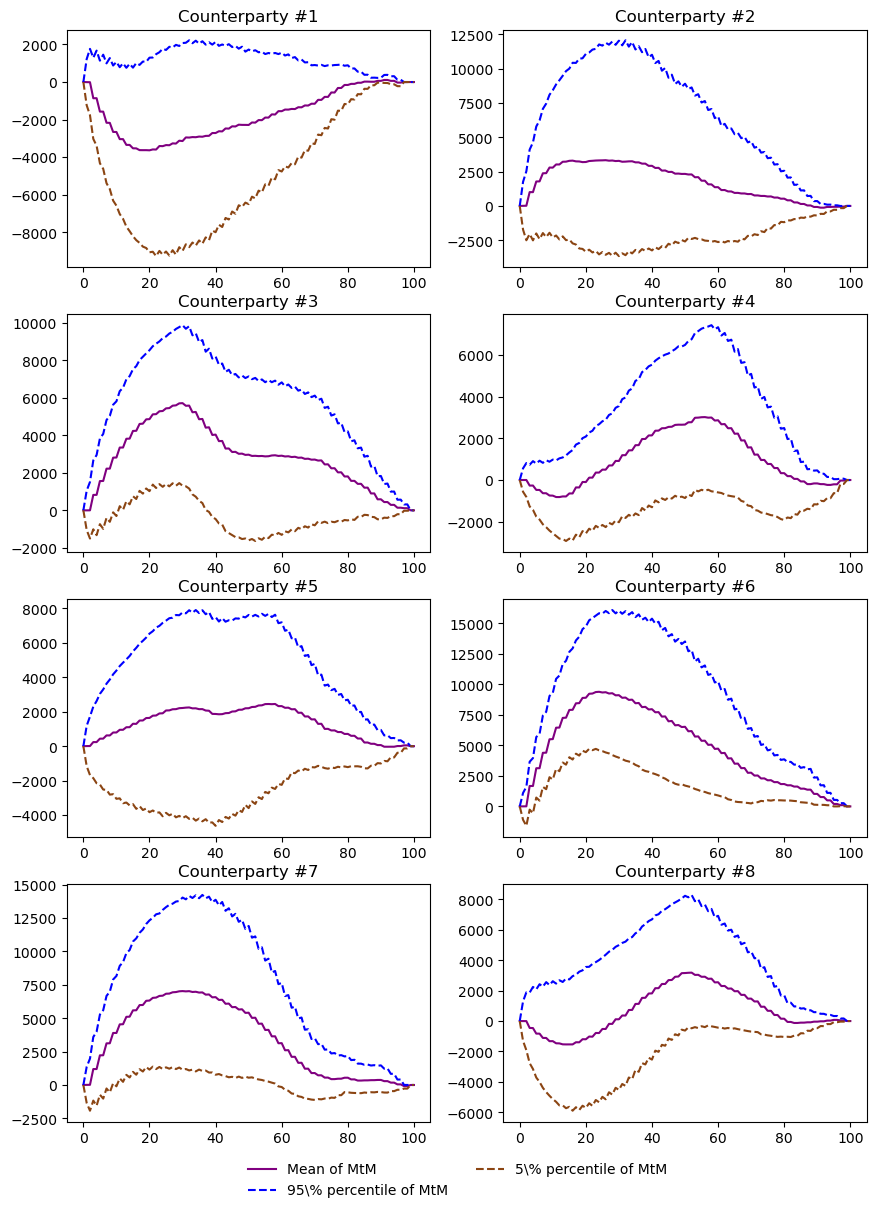

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(10, 14), dpi=100)
for i in range(4):
    for j in range(2):
        axs[i,j].plot(diffusion_engine.mtm_by_cpty[:, 2*i+j].mean(axis=1), color='purple', label='Mean of MtM')
        axs[i,j].plot(np.percentile(diffusion_engine.mtm_by_cpty[:, 2*i+j], 95, axis=1), linestyle='dashed', color='blue', label='95\% percentile of MtM')
        axs[i,j].plot(np.percentile(diffusion_engine.mtm_by_cpty[:, 2*i+j], 5, axis=1), linestyle='dashed', color='saddlebrown', label='5\% percentile of MtM')
        axs[i,j].set_title('Counterparty #{}'.format(2*i+j+1))
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
lgd = axs.flatten()[-1].legend(loc='upper center', bbox_to_anchor=(-0.125, -0.12), ncol=2, frameon=False)